In [10]:
import fceulib
import ppu_dump
import sys
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from fceu_help import pointer_to_numpy
import scipy
import scipy.misc
import cv2
import pickle

In [13]:
#rom = "mario.nes"

movie = 'speed_run.fm2'
start_t =240

rom = "mario.nes"

emu = fceulib.runGame(rom)
inputs1 = fceulib.readInputs(movie)
inputs2 = fceulib.readInputs2(movie)

print len(inputs1)

1956


341


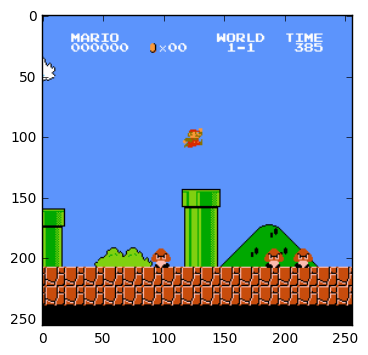

342


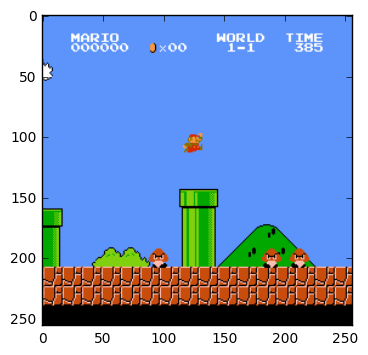

In [22]:
%matplotlib inline
for t in range(341,343,1):
    emu = fceulib.runGame(rom)
    inputs1 = fceulib.readInputs(movie)
    inputs2 = fceulib.readInputs2(movie)
    

    for i,i2 in zip(inputs1[:start_t+t],inputs2[:start_t+t]):
        emu.stepFull(i, i2)

    print t
    def convert_image(img_buffer):
        # TODO: without allocations/reshape?
        screen = pointer_to_numpy(img_buffer)
        return screen.reshape([256, 256, 4]).astype(np.uint8)

    img_buffer = fceulib.VectorBytes()
    emu.imageInto(img_buffer)
    np_image = convert_image(img_buffer)
    plt.imshow(np_image)
    plt.show()

# img = Image.fromarray(scipy.misc.imresize(np_image,1.0))
# print tesserocr.image_to_text(img) 
    

In [ ]:
76, (14, 157), (14, 15), (14, 13))import pickle
end = start_t+1000
print len(inputs1)

with open('inputs.pkl','wb') as outfile:
    i1 = list(inputs1[start_t:end])
    i2 = list(inputs2[start_t:end])
    pickle.dump((i1,i2),outfile)

In [ ]:
%%time

reload(ppu_dump)
#METROID
#scroll_area= (0,0,32,30-0)

#ZELDA
scroll_area= (0,4,32,30-4)

#MARIO, ZELDA2
#scroll_area = (0, 4, 32, 30-4)

ep_data = ppu_dump.ppu_output(emu,
                              inputs1[start_t:end],
                              inputs2=inputs2[start_t:end],
                              bg_data=True,
                              scrolling=True,
                              sprite_data=True,
                              colorized_tiles=False,
                              display=False,
                              test_control=True,
                              peekevery=1,
                            scroll_area= scroll_area )

In [ ]:

from collections import Counter
posx, posy = 0, 0
nt_total = {}
potential_nt_total = {}
nt_totals = [nt_total]
tilex = 0
tiley = 0
interstitial = False
prev = None
curr = None
gap =10
big_gap = 60
timeSinceControl = 0
thresh =1
accum = 0
screen_offsets = {}
room_v_time = {}
accumX = 0
accumY = 0
potential_interstitial = False
correlation_threshold = 0.1
room_start_x = 0
room_start_y = 0
room_starts = {0:(0,0)}
previousTimeSinceControl = 0
raw_scrolls = {}
for t, (sx, sy) in sorted(ep_data["tilemap_motion"].items()):
    if t not in ep_data['screen_corrs']:
        ep_data['screen_corrs'][t] = 1
    #print t, len(ep_data["nametables"])
    nt = ep_data["nametables"][t]
    attr = ep_data["attr"][t]
    pal = ep_data['palettes'][t]
    if sx >= 16:
        sx -= 32
    if sx <= -16:
        sx += 32
    if sy >= 15:
        sy -= 30
    if sy <= -15:
        sy += 30
    tilex += sx
    tiley += sy
        
    raw_scrolls[t] = (tilex,tiley)
    if not ep_data['has_controls'][t]:
        timeSinceControl += 1
    else:
        previousTimeSinceControl = timeSinceControl
        timeSinceControl  = 0
        accumX = 0
        accumY = 0
    if timeSinceControl > 0:
        accumX += sx
        accumY += sy
    if timeSinceControl > gap and ((abs(accumX) >= scroll_area[2]/2 or
                                    abs(accumY) >= scroll_area[3]/2) or 
                                   timeSinceControl > big_gap):
        if not interstitial:
            #print t, timeSinceControl
            #plt.imshow(nt)
            #plt.show()
            pass
        interstitial = True
        potential_nt_total = {}
        potential_interstitial = False
    elif timeSinceControl > gap:
        potential_interstitial  = True
    else:
        if potential_interstitial:
            for key in potential_nt_total:
                if key not in nt_total:
                    nt_total[key] = {}
                for t_ in potential_nt_total[key]:
                    nt_total[key][t_] = potential_nt_total[key][t_]
            potential_nt_total = {}
            potential_interstitial = False
    #print t, timeSinceControl
    if  not (interstitial or potential_interstitial) :
        #print "t", t, "scroll by", sx, sy, tilex, tiley
        for x in range(0, scroll_area[2]):
            for y in range(0, scroll_area[3]):
                key = (y+tiley, x+tilex)
                if key not in nt_total:
                    nt_total[key] = {}
                nt_total[key][t] = (int(nt[y, x]),int(attr[y, x]),pal)
    if potential_interstitial:
        for x in range(0, scroll_area[2]):
            for y in range(0, scroll_area[3]):
                key = (y+tiley, x+tilex)
                if key not in potential_nt_total:
                    potential_nt_total[key] = {}
                potential_nt_total[key][t] = (int(nt[y, x]),int(attr[y, x]),pal)
    if (ep_data['screen_corrs'][t]<correlation_threshold) and ep_data['screen_corrs'][t] > 0:
        
        interstitial = True
    prev = curr
    curr = {}
    diff = 0
    for x in range(0, scroll_area[2]):
        for y in range(0, scroll_area[3]):
            key = (y+tiley, x+tilex)
            if key not in curr:
                curr[key] = (int(nt[y, x]),int(attr[y, x]))
            if prev:
                if key not in prev:
                    diff += 1
                elif curr[key] != prev[key]:
                    diff += 1  
    if (diff > scroll_area[2]*scroll_area[3]*thresh):
        interstitial = True
    #print t, timeSinceControl,interstitial,potential_interstitial,float(diff)/float(scroll_area[2]*scroll_area[3]),accumX,accumY
    
    if ((ep_data['has_controls'][t] and interstitial) or (diff > scroll_area[2]*scroll_area[3]*thresh)) and (ep_data['screen_corrs'][t]>correlation_threshold):
        plt.imshow(nt,interpolation='none')
        plt.show()
        interstitial = False
        nt_total = {}
        nt_totals.append(nt_total)
        for t_ in range(t-previousTimeSinceControl,t):
            room_v_time[t] = len(nt_totals)-1
        room_starts[len(nt_totals)-1] = (ep_data["screen_scrolls"][t][0],
                                         ep_data["screen_scrolls"][t][1])
    room_v_time[t] = len(nt_totals)-1
    if t in ep_data["screen_scrolls"]:       
        screen_offsets[t] = (ep_data["screen_scrolls"][t][0],
                             ep_data["screen_scrolls"][t][1])
    else:
        screen_offsets[t] = (tilex*8,tiley*8)

room_images = []
for nt_id,nt_total in enumerate(nt_totals):
    if len(nt_total) > 0:
        minx = min(map(lambda (y, x): x,nt_total.keys()))
        maxx = max(map(lambda (y, x): x,nt_total.keys()))+1
        miny = min(map(lambda (y, x): y,nt_total.keys()))
        maxy = max(map(lambda (y, x): y,nt_total.keys()))+1
        nt_result = {}
        for x in range(minx, maxx):
            for y in range(miny, maxy):
                if (y,x) in nt_total:
                    nt_result[y-miny, x-minx] = nt_total[(y, x)]
        colorized = ep_data["tile2colorized"]
        out_image = np.zeros(shape=((maxy-miny)*8, (maxx-minx)*8, 4))
        for x in range(0, maxx-minx):
            for y in range(0, maxy-miny):
                col = np.zeros(shape=(8,8,3))
                if (y,x) in nt_result:
                    ind_per_tile = nt_result[y,x].values()
                    i2c = {}
                    for i in ind_per_tile:
                        if i not in i2c:
                            i2c[i] = 0
                        i2c[i] += 1
                    
                    #ind = sorted(nt_result[y, x])

                    #ind = ind[int(len(ind)/4.0)]
                    col = colorized[sorted(i2c.iteritems(), key=lambda (k,v): (v,k))[-1][0]]  # Returns the highest occurring item
                    
                    #col = colorized[nt_result[y, x][ind]]
                out_image[y*8:(y+1)*8, x*8:(x+1)*8, :3] = col/255.
                out_image[y*8:(y+1)*8, x*8:(x+1)*8, 3] = 1.0
        plt.figure(figsize=(20,10)) 
        plt.imshow(out_image)
        room_images.append((out_image,(0,(maxx-minx)*8,0,(maxy-miny)*8)))
        plt.savefig('{}.png'.format(nt_id))
        plt.show()

In [ ]:
%%time
import tracking
reload(tracking)


tracks, old_tracks = tracking.tracks_from_sprite_data(ep_data['sprite_data'],sigma=5,min_gate=5)
for track in tracks:
    old_tracks.append((track,tracks[track]))
  

In [ ]:
world_space_tracks = []
for track in old_tracks[:]:
    for t in sorted(track[1]):
        room_ids = {}
        most_seen = -1
        most_times_seen = -1
        
        if t in screen_offsets:
            room_id = room_v_time[t]  
            if room_id not in room_ids:
                room_ids[room_id] = 0
            room_ids[room_id] += 1
            if room_ids[room_id] > most_times_seen:
                most_times_seen = room_ids[room_id]
                most_seen = room_id
                
    world_space_track = {}
    for t in sorted(track[1]):
        if t in screen_offsets:
            current_offset = np.array(screen_offsets[t]-np.array(room_starts[most_seen]))
            #room_id = room_v_time[t]  
            #print t,room_id
            #print track[1][t][0],screen_offsets[t]np.array(room_starts[most_seen])
            
            point =  track[1][t][0]+current_offset
            bb = track[1][t][1]            
            bb = (bb[0]+current_offset[0],bb[1]+current_offset[1],
                               bb[2]+current_offset[0],bb[3]+current_offset[0],
                               bb[4]+current_offset[1],bb[5]+current_offset[1],
                               bb[6],bb[7])
            
            sprites = track[1][t][2]
            modified_sprites = []
            for sprite in sprites:
                loc = np.array(sprite[1][:2])
                corner = np.array((track[1][t][1][2],track[1][t][1][4]))
                
                modified_sprites.append((sprite[0], corner-loc))
            
            world_space_track[t] = (point,bb, modified_sprites)
    world_space_tracks.append((track[0],world_space_track))

tile_tracks = []
max_t = -1
for nt_id,nt_total in enumerate(nt_totals):
    if len(nt_total) > 0:
        minx = min(map(lambda (y, x): x,nt_total.keys()))
        maxx = max(map(lambda (y, x): x,nt_total.keys()))+1
        miny = min(map(lambda (y, x): y,nt_total.keys()))
        maxy = max(map(lambda (y, x): y,nt_total.keys()))+1
        nt_result = {}
        for x in range(minx, maxx):
            for y in range(miny, maxy):
                if (y,x) in nt_total:
                    nt_result[y-miny, x-minx] = nt_total[(y, x)]
                    #tile_tracks[y-miny, x-minx] = nt_total[(y, x)]
                    trackID = 'tile{},{}'.format(y-miny, x-minx)
                    xcoord = (x-minx)*8
                    ycoord = (y-miny)*8
                    track = {t:(np.array((xcoord+4,ycoord+4)),(xcoord+4,ycoord+4,xcoord,xcoord+8,ycoord,ycoord+8,8.,8.),i) for t,i in nt_total[(y, x)].items()}
                    tile_tracks.append((trackID, track))

In [ ]:
pickle.dump(ep_data["tile2colorized"],open('tile2colorized.pkl','wb'))

In [ ]:
pickle.dump(tile_tracks,open('tile_tracks.pkl','wb'))

In [ ]:
pickle.dump(world_space_tracks,open('all_tracks.pkl','wb'))

In [ ]:
ind = 0
for track in old_tracks:
    print ind
    ind +=1
    pts = []
    for t in sorted(track[1]):
        room_ids = {}
        most_seen = -1
        most_times_seen = -1
        
        if t in screen_offsets:
            room_id = room_v_time[t]  
            if room_id not in room_ids:
                room_ids[room_id] = 0
            room_ids[room_id] += 1
            if room_ids[room_id] > most_times_seen:
                most_times_seen = room_ids[room_id]
                most_seen = room_id
    offset = np.array([0.5,0.5])
    actual_track = []
    for t in sorted(track[1]):
        if t in screen_offsets:
            #room_id = room_v_time[t]  
            #print t,room_id
            #print track[1][t][0],screen_offsets[t]np.array(room_starts[most_seen])
            pts.append(track[1][t][0]+np.array(screen_offsets[t]-np.array(room_starts[most_seen])))
            actual_track.append(pts)
            bounding_box = track[1][t][1]
            half_extent = np.array(bounding_box[-2:])/2.0
            pts.append(track[1][t][0]+offset+np.array(screen_offsets[t]-np.array(room_starts[most_seen]))-half_extent)
            pts.append(track[1][t][0]+offset+np.array(screen_offsets[t]-np.array(room_starts[most_seen]))+half_extent*np.array([-1,1]))
            pts.append(track[1][t][0]+offset+np.array(screen_offsets[t]-np.array(room_starts[most_seen]))+half_extent)
            pts.append(track[1][t][0]+offset+np.array(screen_offsets[t]-np.array(room_starts[most_seen]))+half_extent*np.array([1,-1]))
            pts.append(track[1][t][0]+offset+np.array(screen_offsets[t]-np.array(room_starts[most_seen]))-half_extent)
            pts.append(track[1][t][0]+offset+np.array(screen_offsets[t]-np.array(room_starts[most_seen])))
            
    pts = np.array(pts)
    plt.figure(figsize=(20,10)) 
    plt.imshow(room_images[room_id][0],origin='upper')
    plt.plot(pts[:,0],208-pts[:,1],'w')
    plt.axis([room_images[room_id][1][0],room_images[room_id][1][1],room_images[most_seen][1][3],room_images[most_seen][1][2]])
    plt.show()


In [ ]:
import random

def encode(input_string):
    count = 1
    prev = ''
    lst = []
    for character in input_string:
        if character != prev:
            if prev != '':
                entry = (prev,count)
                lst.append(entry)
                #print lst
            count = 1
            prev = character
        else:
            count += 1
    else:
        entry = (character,count)
        lst.append(entry)
    return lst

def circular_match(animation_1,animation_2):
    swapped = False
    if len(animation_1) == 1 or len(animation_2) == 1:
        return (False,0,0)
    if len(animation_2) < len(animation_1):
        temp = animation_2
        animation_2 = animation_1
        animation_1 = temp
        swapped = True
    if len(animation_1) == len(animation_2):
        #can we rotate to get an alignment
        for offset in range(0,len(animation_1)):
            good = True
            for index in range(len(animation_1)):
                offset_index = (index+offset) % len(animation_1)
                if animation_1[offset_index] != animation_2[index]:
                    good = False
            if good:
                return (True,0,offset)
        return (False,0,0)
    else:
        #can we find it inside, with perhaps some wrapping
        for index2 in range(-len(animation_1),len(animation_2)-len(animation_1)): 
            good = True           
            for index in range(len(animation_1)):
                if animation_1[index] != animation_2[index2+index]:
                    good = False
            if good:
                if swapped:
                    return (True,0,index2)
                else:
                    return (True,index2,0)
                    
        return (False,0,0)
def repeat(s):
    prefix_array=[]
    for i in range(1,int(len(s)/2)+1):
        prefix_array.append(s[:i])
    #see what it holds to give you a better picture
    for i in prefix_array:
        if len(s) % len(i) == 0:
            if i*(len(s)/len(i)) == s:
                return i,(len(s)/len(i))

    return s,1

def get_cycles(trace,split):
    index = 0
    new_trace = []
    cycles = {}
    new_split = []
    for s in split:    
        cycle = tuple(trace[index:index+s])
        cycle, repetitions= repeat(cycle)    
        
        index += s
        if cycle not in cycles:
            cycles[cycle] = len(cycles)
        new_trace += [cycles[cycle]]*repetitions
        new_split += [len(cycle)]*repetitions
        
        
    id2cycle = {i:v for v,i in cycles.items()}
    
    subsets = {}
    for cycle1 in cycles:
        for cycle2 in cycles:
            if cycle1 != cycle2:
                match,offset1,offset2 = circular_match(cycle1,cycle2)
                #if match and (len(cycle1) <= len(cycle2)) and cycles[cycle1] < cycles[cycle2]:
                if match and (len(cycle1) == len(cycle2)) and cycles[cycle1] < cycles[cycle2]:
                    if cycle1 in subsets:
                        previous = subsets[cycle1]
                        if len(previous) > len(cycle2):
                            subsets[cycle1] = cycle2
                    else:
                        subsets[cycle1] = cycle2
    
            
    return cycles,new_trace,subsets,new_split
 
print get_cycles([0,1,2,1,0,1,2,1],[8])
#print get_cycles([0,1,2,1,0,1,2,1,0,1,2,3,4,4,4,1,2,1,0],[4,4,3,1,1,1,1,4])

In [ ]:
   
def score(trace,split):
    cycles,new_trace,subsets,new_split = get_cycles(trace,split)
    rle_encoded  = encode(new_trace)
    size = 0
    for s in cycles:
        if s not in subsets:
            size += len(s)
    return size+len(rle_encoded),rle_encoded,subsets,new_split
        
def mutate(split,trace):
    cycles,new_trace,subsets,new_split = get_cycles(trace,split)
    counts = {}
    for t in new_trace:
        
        if t not in counts:
            counts[t] = 0.0
        counts[t] += 1.0
    split = new_split
    
    inv_count = {t:(1.0/counts[t])**3.0 for t in counts}
    
    total = np.sum([inv_count[t] for t in new_trace])
    #for t in new_trace:
    #    print t, inv_count[t]
    
    split_id = 0
    split_val = random.random()*total
    for t in new_trace:
        split_val -= inv_count[t]
        if split_val <= 0:
            break
        split_id += 1
    
    
    #split_id = random.randint(0,len(split)-1)
    new_split = [s for s in split]
    if random.random() < 0.5 and split[split_id] > 1:
        split_left = split[split_id]
        split_right = random.randint(1,split_left)
        split_left -= split_right
        if not (split_left == 0 or split_right == 0):
            new_split = new_split[:split_id] + [split_left,split_right] + new_split[split_id+1:]
    elif random.random() < 0.5 and  split_id != 0:
        new_split =  new_split[:split_id-1] + [ new_split[split_id-1]+new_split[split_id]] + new_split[split_id+1:]
    elif random.random() < 0.5 and  split_id < len(new_split)-1:
        new_split =  new_split[:split_id] + [ new_split[split_id]+ new_split[split_id+1]] + new_split[split_id+2:]
    return new_split

def crossover(split_left,split_right):
    sum = reduce(lambda x,y:x+y,split_left)
    crossover_point = random.randint(1,sum-1)
    running_total = 0
    left_left = []
    left_right = []
    for left_point in range(len(split_left)):
        running_total += split_left[left_point]
        if running_total >= crossover_point:
            left_carry_over = running_total-crossover_point
            if left_carry_over == 0:
                left_left.append(split_left[left_point])
                left_right = split_left[left_point+1:]
            else:
                left_left.append(split_left[left_point]-left_carry_over)
                left_right = [left_carry_over]+split_left[left_point+1:]
            break
        left_left.append(split_left[left_point])
    right_left = []
    right_right = []
    running_total = 0
    for right_point in range(len(split_right)):
        running_total += split_right[right_point]
        if running_total >= crossover_point:
            right_carry_over = running_total-crossover_point
            if right_carry_over == 0:
                right_left.append(split_right[right_point])
                right_right = split_right[right_point+1:]
            else:
                right_left.append(split_right[right_point]-right_carry_over)
                right_right = [right_carry_over]+split_right[right_point+1:]
            break
        right_left.append(split_right[right_point])
    return left_left + right_right, right_left + left_right

  

In [ ]:
def find_animations(raw_data,population_size = 200,generations=200,proportion_to_keep=0.5,mutation_count=4,crossover_amount=0.1,population=None):
    selection = 'Tournament'
    data = [e[0] for e in raw_data]
    keep_each = int(proportion_to_keep*population_size)
    crossover_amount = int(population_size*crossover_amount)
    best_score = float('inf')
    if not population:
        print 'new population'
        population = []
        for ii in range(population_size):
            splits = random.randint(int(len(data)*0.5),len(data))
            split = [len(data)]
            for jj in range(splits):
                split_id = random.randint(0,len(split)-1)
                split_left = split[split_id]
                split_right = random.randint(1,split_left)
                split_left -= split_right
                if not (split_left == 0 or split_right == 0):
                    split = split[:split_id] + [split_left,split_right] + split[split_id+1:]
                    
            population.append(split)
    def score_population(population):
        scored = {}
        for split_id in range(len(population)): 
            split = population[split_id]
            current,encoded,_,split = score(data,split)
            population[split_id] = split
            if current not in scored:
                scored[current] = []
            scored[current].append(split)
        return scored

    for generation in range(generations):
        print 'generation', generation
        current_population = []
        scored = score_population(population)
        print '\t',list(sorted(scored))[0]
        if selection == 'FitnessProportionate':
            scores = []
            for s in sorted(scored):
                current_population += scored[s]
                scores += [s]*len(scored[s])

            total = 0
            for i,s in enumerate(scores):
                scores[i] = np.exp(-s/2.0)
                total += scores[i]
            for i,s in enumerate(scores):
                scores[i] /= total

            #print scores
            new_population = []
            for ii in range(keep_each):
                rv = random.random()
                for s,member in zip(scores,current_population):
                    rv -= s
                    if rv < 0:
                        new_population.append([c for c in member])
                        break
        else:
            new_population = []
            for s in sorted(scored):
                current_population += scored[s]
                
            for ii in range(keep_each):
                for member in current_population:
                    if random.random() < proportion_to_keep:
                        new_population.append(member)
                        break
            
        current_population = new_population
        
        #current_population = current_population[:keep_each]
        while len(current_population) != population_size:
            mutated = random.choice(current_population)
            for ii in range(mutation_count):
                mutated = mutate(mutated,data)
            current_population.append(mutated)
        for ii in range(crossover_amount):
            id1 = random.randint(0,population_size-1)
            id2 = random.randint(0,population_size-1)
            new1,new2 = crossover(population[id1],population[id2])
            population[id1] = new1
            population[id2] = new2
        population = current_population
    scored = score_population(population)
    best_score = list(sorted(scored))[0]
    best_split = scored[best_score][0]
    cycles,new_trace,subsets,new_split = get_cycles(data,best_split)
    id2cycle = {v:k for k,v in cycles.items()}
    previous_cycle_id = -1
    animations = []
    animation_ids = []
    times_seen = {}
    for cycle_id in new_trace:
        if cycle_id not in times_seen:
            times_seen[cycle_id] = 0
        times_seen[cycle_id] += 1
        
    for cycle_id in new_trace:    
        cycle1 = id2cycle[cycle_id]
        if cycle1 in subsets:
            cycle2 = subsets[cycle1]
            match, offset1,offset2 = circular_match(cycle1,cycle2)
            animation_ids.append((cycles[cycle2],offset1,len(cycle1)))
        else:
            animation_ids.append((cycle_id,0,len(cycle1)))
        animations.append(cycle1)
    
    raw_id = 0
    time_animations = []
    for animation in animations:
        time_animation = []
        time_animations.append(time_animation)
        for frame in animation:
            time_in_frame = raw_data[raw_id][1]
            time_animation.append((frame,time_in_frame))
            raw_id += 1
    
    
    return animation_ids, animations,time_animations,population

In [ ]:
track = old_tracks[15][1]
blobbed_sprites = {}
animation = []
for t in sorted(track):
    point = track[t]
    
    blob = {}
    for sprite in point[2]:
        img = sprite[0]
        loc = np.array(sprite[1][:2])
        blob[img] = tuple(loc-point[1][:2])
    blob = tuple([(img,blob[img]) for img in sorted(blob)])
    if blob not in blobbed_sprites:
        blobbed_sprites[blob] = len(blobbed_sprites)
    animation.append(blobbed_sprites[blob])
    
    

animation_arr = np.array(animation)
plt.figure(figsize=(40,5))
plt.plot(animation_arr)
plt.show()

i2b = {blobbed_sprites[b]:b for b in blobbed_sprites}

for i in sorted(i2b):
    blob = i2b[i]
    minx = np.min([sprite[1][0] for sprite in blob])
    maxx = np.max([sprite[1][0] for sprite in blob])
    miny = np.min([sprite[1][1] for sprite in blob])
    maxy = np.max([sprite[1][1] for sprite in blob])
    img = np.zeros((int(maxy-miny)+8,int(maxx-minx)+8,4))
    for sprite in blob:
        left = int(sprite[1][0]-minx)
        top =  int(sprite[1][1]-miny)
        img[top:(top+8),left:(left+8)] = ep_data['id2colorized'][sprite[0]][:,:,:]/255.0
    scipy.misc.imsave('anim_{}.png'.format(i),img)
    

encoding = encode(animation)
expanded_encoding = []
time_split = 15
for e in encoding:
    time = e[1]
    while time > 0:
        if time < time_split:
            expanded_encoding.append((e[0],time))
        else:
            expanded_encoding.append((e[0],time_split))
        time -= time_split
for ii in range(10):
    animation_splits =  find_animations(expanded_encoding,population_size = 1000,proportion_to_keep=0.15,generations=150)

for s in subsets:
    print s, subsets[s]


print ''
for id, anim in zip(animation_splits[0],animation_splits[1]):
    print id, anim

In [ ]:
%%time
expanded_encoding = []
time_split = 15
for e in encoding:
    time = e[1]
    while time > 0:
        if time < time_split:
            expanded_encoding.append((e[0],time))
        else:
            expanded_encoding.append((e[0],time_split))
        time -= time_split
temp = animation_splits
animation_splits =  find_animations(expanded_encoding,population_size = len(animation_splits[-1]),
                                    proportion_to_keep=0.25,
                                    generations=2,
                                    population=animation_splits[-1])
for s in subsets:
    print s, subsets[s]


print ''
for id, anim in zip(animation_splits[0],animation_splits[1]):
    print id, anim

In [ ]:
def room2attr(room):
    
    minx = min(map(lambda (y, x): x,room.keys()))
    maxx = max(map(lambda (y, x): x,room.keys()))+1
    miny = min(map(lambda (y, x): y,room.keys()))
    maxy = max(map(lambda (y, x): y,room.keys()))+1
    attr_room = np.zeros((maxy-miny,maxx-minx,2))
    for x in range(minx, maxx):
        for y in rSuper Mario BrosSuper Mario Brosange(miny, maxy):
            if (y,x) in room:
                ind = sorted(room[y, x])[0]
                attr_room[int(y-miny), int(x-minx),:] = np.array(room[(y, x)][ind][:-1])
    return attr_room
unions = UnionFind()

def dict_compare(d1, d2):
    d1_keys = set(d1.keys())
    d2_keys = set(d2.keys())
    intersect_keys = d1_keys.intersection(d2_keys)
    added = d1_keys - d2_keys
    removed = d2_keys - d1_keys
    modified = {o : (d1[o], d2[o]) for o in intersect_keys if d1[o] != d2[o]}
    same = set(o for o in intersect_keys if d1[o] == d2[o])
    return added, removed, modified, same

for room_id,room in enumerate(nt_totals):
    minx = min(map(lambda (y, x): x,room.keys()))
    maxx = max(map(lambda (y, x): x,room.keys()))+1
    miny = min(map(lambda (y, x): y,room.keys()))
    maxy = max(map(lambda (y, x): y,room.keys()))+1

    for other_id,other in enumerate(nt_totals):
        if len(room) > 0 and len(other) > 0:
time_animations [[(20, 4), (21, 8), (20, 8)], [(22, 24), (20, 8), (21, 9), (20, 7)], [(22, 24), (20, 8), (21, 8), (20, 8)], [(22, 24), (20, 8), (21, 8), (20, 8)], [(22, 25), (20, 7), (21, 8), (20, 8)], [(22, 24), (20, 8), (21, 8), (20, 8)], [(22, 24), (20, 8), (21, 8), (20, 8)], [(22, 24), (20, 8), (21, 8), (20, 8)], [(22, 24), (20, 8), (21, 10), (20, 6)]]
            if room2attr(room).shape == room2attr(other).shape:
                if np.sum(np.abs(room2attr(room)-room2attr(other))) == 0:
                    unions.union(room_id,other_id)

            
cluster2room = {}

for u in unions:
    if unions[u] not in cluster2room:
        cluster2room[unions[u]] = set()
    cluster2room[unions[u]].add(u)
print 'digraph G{\n\trankdir=LR;\npenwidth=10;\nnode[shape=none];\n'

for cluster in cluster2room:
    print '\tsubgraph cluster_{} {{'.format(cluster)
    print '\t\tcolor=blue;'
    for room in cluster2room[cluster]:
        print '\t\t n{}[image="{}.png", label="{}", fontsize=240,fontcolor=red];'.format(room,room,room);
    print '\t}'
for ii in range(1,len(nt_totals)):
    print 'n{} -> n{} [penwidth=10];'.format(ii-1,ii)
print '}'

In [ ]:
time_split = 60

animation_maps = []
color_ids = {}
for nt_id,nt_total in enumerate(nt_totals):
    if len(nt_total) > 0:
        minx = min(map(lambda (y, x): x,nt_total.keys()))
        maxx = max(map(lambda (y, x): x,nt_total.keys()))+1
        miny = min(map(lambda (y, x): y,nt_total.keys()))
        maxy = max(map(lambda (y, x): y,nt_total.keys()))+1
        nt_result = {}
        animation_maps.append(nt_result)
        for x in range(minx, maxx):
            for y in range(miny, maxy):
                if (y,x) in nt_total:
                    nt_result[y-miny, x-minx] = nt_total[(y, x)]
                    
                    ids = [nt_result[y-miny, x-minx][t] for t in sorted(nt_result[y-miny, x-minx])]
                    colors = [tuple(colorized[d].ravel()) for d in ids]
                    for c in colors:
                        if c not in color_ids:
                            color_ids[c] = len(color_ids)
                    colors = [color_ids[c] for c in colors]
                    
                    if len(set(colors)) > 1:
                        encoding = encode(colors)
                        expanded_encoding = []
                        
                        for e in encoding:
                            time = e[1]
                            while time > 0:
                                if time < time_split:
                                    expanded_encoding.append((e[0],time))
                                else:
                                    expanded_encoding.append((e[0],time_split))
                                time -= time_split
                        nt_result[y-miny, x-minx] = find_animations(expanded_encoding)
                        
                    else:
                        encoding = encode(colors)
                        nt_result[y-miny, x-minx] = ((0,0,1),[[encoding[0][0]]],[[encoding]])
                        

In [ ]:
print '\t'.join([str(e[0]) for e in expanded_encoding])



In [ ]:
hand_tuned_split = [3,3,3,3,3,3,2,1,1,1,2,1,1,1,1,3,3,1,1,3,1,1,1,1,2,3,3,3,3,3,1,2,1,1,1,1,2,2,2,1,2,2,1,1,1,1,2,1,1,1,3,1,1,1,3,1,1,1,1,1,3,1,1,1,3,1,1,1,1,1,1,1,3,3,1,1,1,3,3,2,3,3,3,3,1,1,1,1,3,3,3,3,3,1,3,3,3,3,3,3,3,2,1]
hand_tuned_split =[3,3,3,3,3,3,2,1,1,1,2,1,1,1,1,3,3,1,1,3,1,1,1,1,1,3,3,3,3,3,1,2,1,1,1,1,2,2,2,1,2,1,1,1,1,1,1,2,1,1,1,3,1,1,1,3,1,1,1,1,1,3,1,1,1,3,1,1,1,1,1,1,1,3,3,1,1,1,3,3,2,3,3,3,3,1,1,1,1,3,3,3,3,3,1,3,3,3,3,3,3,3,2,1]
print score([e[0] for e in expanded_encoding],hand_tuned_split)


cycles,new_trace,subsets,new_split = get_cycles([e[0] for e in expanded_encoding],hand_tuned_split)
for s in subsets:
    print s, subsets[s]


In [ ]:
track = old_tracks[15]
pts = []
for t in sorted(track[1]):
    pts.append(track[1][t][0])
    
    
pts = np.array(pts)

import pickle
pickle.dump(pts,open('track.pkl','wb'))